In [1]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle

ROOT = os.path.dirname(os.getcwd())

# Motivation:
Here we are simply checking the motivations behind the H statistic in the first place. We will see the correlation between average number of passes vs performannce

In [46]:
nation = 'England'
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
display(events)

eventId           subEventName  \
Italy 0             8            Simple pass   
      1             8            Simple pass   
      2             7                  Touch   
      3             1  Ground attacking duel   
      4             1  Ground attacking duel   
...               ...                    ...   
Spain 628654        8            Simple pass   
      628655        7           Acceleration   
      628656        8                  Cross   
      628657        8            Simple pass   
      628658        7              Clearance   

                                                  tags  playerId  \
Italy 0                                 [{'id': 1801}]      8327   
      1                                 [{'id': 1801}]     20438   
      2                                             []      8306   
      3       [{'id': 504}, {'id': 703}, {'id': 1801}]      8306   
      4       [{'id': 503}, {'id': 703}, {'id': 1801}]      8306   
...                                                ...       ...   
Spain 628654                            [{'id': 1801}]     20623   
      628655                            [{'id': 1801}]    122832   
      628656               [{'id': 401}, {'id': 1802}]    122832   
      628657                            [{'id': 1801}]     40756   
      628658              [{'id': 1401}, {'id': 1802}]      3306   

                                              positions  matchId  \
Italy 0        [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]  2575959   
      1        [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]  2575959   
      2        [{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]  2575959   
      3        [{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]  2575959   
      4        [{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]  2575959   
...                                                 ...      ...   
Spain 628654    [{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]  2565927   
      628655    [{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]  2565927   
      628656   [{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]  2565927   
      628657     [{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]  2565927   
      628658  [{'y': 56, 'x': 9}, {'y': 100, 'x': 100}]  2565927   

                       eventName  teamId matchPeriod     eventSec subEventId  \
Italy 0                     Pass    3158          1H     2.530536         85   
      1                     Pass    3158          1H     3.768418         85   
      2       Others on the ball    3158          1H     4.868265         72   
      3                     Duel    3158          1H     8.114676         11   
      4                     Duel    3158          1H     8.647892         11   
...                          ...     ...         ...          ...        ...   
Spain 628654                Pass     682          2H  2939.077491         85   
      628655  Others on the ball     682          2H  2940.515560         70   
      628656                Pass     682          2H  2942.098761         80   
      628657                Pass     675          2H  2943.089232         85   
      628658  Others on the ball     675          2H  2943.668846         71   

                     id  
Italy 0       180423957  
      1       180423958  
      2       180423959  
      3       180423960  
      4       180423961  
...                 ...  
Spain 628654  253302671  
      628655  253302673  
      628656  253302674  
      628657  253302698  
      628658  253302695  

[3071395 rows x 12 columns]

# Step 1: Find Average Passes / Game
We will find the total count of passing events by team and divide by the number of 

In [47]:
events_passing = events.loc[events['eventName']=='Pass']
average_passes_per_game = (events_passing[['teamId', 'matchId']].groupby(['teamId']).count()) / (events_passing[['teamId', 'matchId']].drop_duplicates().groupby(['teamId']).count())
average_passes_per_game.columns = ['avg_pass_per_game']
average_passes_per_game

,avg_pass_per_game
teamId,
674,413.789474
675,581.078947
676,612.105263
677,382.605263
678,395.315789
...,...
3795,360.605263
3799,379.105263
3804,390.131579


#### Average Shots/Game

In [52]:
events_shots = events.loc[events['eventName'] == 'Shot']
average_shots_per_game = (events_shots[['teamId', 'matchId']].groupby(['teamId']).count()) / (events_passing[['teamId', 'matchId']].drop_duplicates().groupby(['teamId']).count())
average_shots_per_game.columns = ['avg_shots_per_game']
average_shots_per_game

,avg_shots_per_game
teamId,
674,11.000000
675,16.605263
676,13.210526
677,10.657895
678,9.921053
...,...
3795,8.578947
3799,10.736842
3804,10.368421


#### Average Goals/Game

In [83]:
events_shots['Goal'] = (events_shots['tags'].apply(lambda tags: any([tag in [{'id': 101}] for tag in tags]))).astype(int)
average_goals_per_game = (events_shots[['teamId', 'Goal']].groupby(['teamId']).sum()) / (events_passing[['teamId', 'matchId']].drop_duplicates().groupby(['teamId']).count()).values
average_goals_per_game.columns = ['avg_goals_per_game']
average_goals_per_game

<ipython-input-83-aa8629a173e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_shots['Goal'] = (events_shots['tags'].apply(lambda tags: any([tag in [{'id': 101}] for tag in tags]))).astype(int)


,avg_goals_per_game
teamId,
674,1.421053
675,2.131579
676,2.289474
677,0.921053
678,0.842105
...,...
3795,0.710526
3799,0.947368
3804,1.236842


#### Average Shots/Game

In [98]:
matches = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'matches_df.pkl.gz'))
matches

,,competitionId,date,duration,gameweek,goalsET_away,goalsET_home,goalsHT_away,goalsHT_home,goalsPen_away,goalsPen_home,goals_away,goals_home,label,roundId,seasonId,status,team_away,team_home,venue,winner
wyId,nation,,,,,,,,,,,,,,,,,,,,
2499719,England,364,"August 11, 2017 at 8:45:00 PM GMT+2",Regular,1,0,0,2,2,0,0,3,4,"Arsenal - Leicester City, 4 - 3",4405654,181150,Played,1631,1609,Emirates Stadium,1609
2499720,England,364,"August 12, 2017 at 6:30:00 PM GMT+2",Regular,1,0,0,0,0,0,0,2,0,"Brighton & Hove Albion - Manchester City, 0 - 2",4405654,181150,Played,1625,1651,The American Express Community Stadium,1625
2499721,England,364,"August 12, 2017 at 4:00:00 PM GMT+2",Regular,1,0,0,3,0,0,0,3,2,"Chelsea - Burnley, 2 - 3",4405654,181150,Played,1646,1610,Stamford Bridge,1646
2499722,England,364,"August 12, 2017 at 4:00:00 PM GMT+2",Regular,1,0,0,2,0,0,0,3,0,"Crystal Palace - Huddersfield Town, 0 - 3",4405654,181150,Played,1673,1628,Selhurst Park,1673
2499723,England,364,"August 12, 2017 at 4:00:00 PM GMT+2",Regular,1,0,0,0,1,0,0,0,1,"Everton - Stoke City, 1 - 0",4405654,181150,Played,1639,1623,Goodison Park,1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576334,Italy,524,"May 19, 2018 at 3:00:00 PM GMT+2",Regular,38,0,0,0,0,0,0,1,2,"Juventus - Hellas Verona, 2 - 1",4406278,181248,Played,3194,3159,,3159
2576335,Italy,524,"May 20, 2018 at 8:45:00 PM GMT+2",Regular,38,0,0,1,2,0,0,3,2,"Lazio - Internazionale, 2 - 3",4406278,181248,Played,3161,3162,,3161
2576336,Italy,524,"May 20, 2018 at 8:45:00 PM GMT+2",Regular,38,0,0,1,0,0,0,1,0,"Sassuolo - Roma, 0 - 1",4406278,181248,Played,3158,3315,MAPEI Stadium - Citt\u00e0 del Tricolore,3158


In [135]:
df = matches[['team_home', 'team_away', 'winner']]
points = dict()
for i, row in df.iterrows():
    #If not draw give the winner 3 points
    if not row['winner'] == 0:
        winner = row['winner']
        if winner not in points.keys():
            points[winner] = 3
        else:
            points[winner] += 3
    #If draw give both home and away 1 pt each
    else:
        home = row['team_home']
        away = row['team_away']
        
        if home not in points.keys():
            points[home] = 1
        else:
            points[home] += 1
            
        if away not in points.keys():
            points[away] = 1
        else:
            points[away] += 1
            
points = pd.Series(points).to_frame('end_of_season_pts').sort_index()
points

,end_of_season_pts
674,73
675,76
676,93
677,29
678,43
...,...
3795,33
3799,43
3804,46
10531,33


In [128]:
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
teams = teams[['name', 'city', 'wyId', 'area.name']].set_index(['wyId']).sort_index()
teams

,name,city,area.name
wyId,,,
674,Valencia,Valencia,Spain
675,Real Madrid,Madrid,Spain
676,Barcelona,Barcelona,Spain
677,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain
678,Athletic Club,Bilbao,Spain
...,...,...,...
16871,Costa Rica,San Jos\u00e9,Costa Rica
17322,Serbia,Beograd,Serbia
17929,Panama,Ciudad de Panam\u00e1,Panama


In [138]:
pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))

,city,name,wyId,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,club,England,0,XEN,
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,club,Spain,724,ESP,ES
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,club,Spain,724,ESP,ES
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,club,Spain,724,ESP,ES
4,Valencia,Levante,695,Levante UD,club,Spain,724,ESP,ES
...,...,...,...,...,...,...,...,...,...
137,Las Rozas,Spain,1598,Spain,national,Spain,724,ESP,ES
138,Beograd,Serbia,17322,Serbia,national,Serbia,688,SRB,RS
139,Bern,Switzerland,6697,Switzerland,national,Switzerland,756,CHE,CH
140,Warszawa,Poland,13869,Poland,national,Poland,616,POL,PL


# Step 2: Combine Everything, See Correlations

In [144]:
df = pd.concat([teams, 
               average_passes_per_game,
               average_shots_per_game,
               average_goals_per_game,
               points], axis=1, join='inner')
df = df.replace({'Wales':'England', 'Monaco':'France'})
df

,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43
...,...,...,...,...,...,...,...
3795,Troyes,Troyes,France,360.605263,8.578947,0.710526,33
3799,Angers,Angers,France,379.105263,10.736842,0.947368,43
3804,Dijon,Dijon,France,390.131579,10.368421,1.236842,46
10531,Swansea City,Swansea,England,390.578947,8.000000,0.684211,33


# Visualizations

In [173]:
df = df.sort_values('area.name')

<Figure size 1080x360 with 0 Axes>

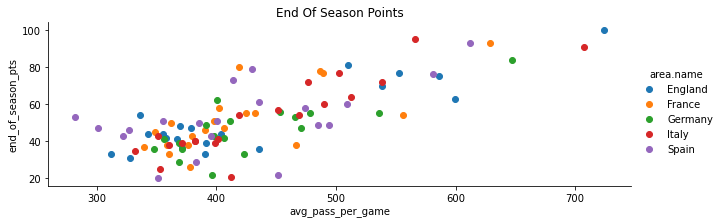

<Figure size 1080x360 with 0 Axes>

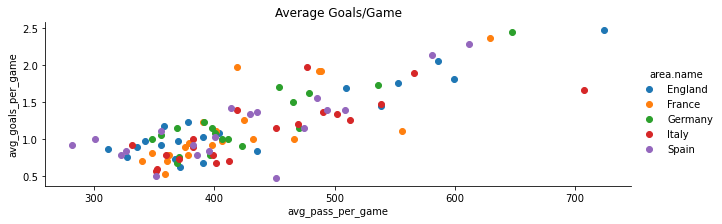

<Figure size 1080x360 with 0 Axes>

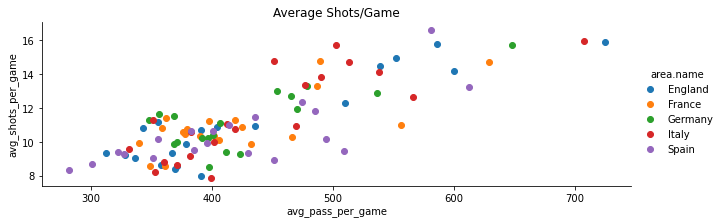

In [210]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'avg_pass_per_game', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/prelim_H_oct_5/avg_pts.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'avg_pass_per_game', 'avg_goals_per_game').add_legend()
plt.title('Average Goals/Game')
plt.savefig('../figures/prelim_H_oct_5/avg_goals.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'avg_pass_per_game', 'avg_shots_per_game').add_legend()
plt.title('Average Shots/Game')
plt.savefig('../figures/prelim_H_oct_5/avg_shots.png', bbox_inches='tight')
plt.show()

### Correlation matrix

In [228]:
corr = df.corr()
corr

,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
avg_pass_per_game,1.000000,0.803065,0.812468,0.763279
avg_shots_per_game,0.803065,1.000000,0.774971,0.719890
avg_goals_per_game,0.812468,0.774971,1.000000,0.873299
end_of_season_pts,0.763279,0.719890,0.873299,1.000000


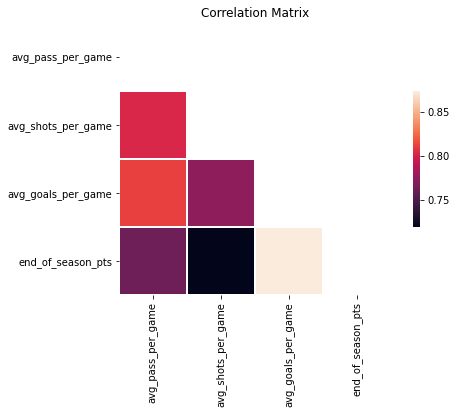

In [233]:
import seaborn as sns
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 5))
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.savefig('../figures/prelim_H_oct_5/correlation_matrix.png', bbox_inches='tight')
plt.show()